In [1]:
from time import time
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


In [2]:
# GLOBAL SETTINGS

# Data directories

#coin_dataDir = 'DATA/TESTDIR/' # Debug dir for testing I/O logic and/or issues. It should be a clone of the above dir.
model_dataDir = 'DATA/MODELDATA/'
plot_dataDir = 'DATA/INITIAL_INSIGHTS/MOMENTUM_FACTORS/STATINFER/'
model_plot_dataDir = 'DATA/MODELRESULTS/'

# Time periods settings
YEAR = 365

# Helpers
sns.set_style('darkgrid')
idx = pd.IndexSlice

# END GLOBAL SETTINGS

In [3]:
# HELPER FUNCTIONS

# Prediction vs Actual Scatter Plot
def plot_preds_scatter(df, ticker=None):
    if ticker is not None:
        idx = pd.IndexSlice
        df = df.loc[idx[ticker, :], :]
    j = sns.jointplot(x='predicted', y='actuals',
                      robust=True, ci=None,
                      line_kws={'lw': 1, 'color': 'k'},
                      scatter_kws={'s': 1},
                      data=df,
                      kind='reg')
    j.ax_joint.yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
    j.ax_joint.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: '{:.1%}'.format(x)))
    j.ax_joint.set_xlabel('Predicted')
    j.ax_joint.set_ylabel('Actuals')

# Daily Information Coefficient(IC) Distribution
def plot_ic_distribution(df, ax=None):
    if ax is not None:
        sns.distplot(df.ic, ax=ax)
    else:
        ax = sns.distplot(df.ic)
    mean, median = df.ic.mean(), df.ic.median()
    ax.axvline(0, lw=1, ls='--', c='k')
    ax.text(x=.05, y=.9,
            s=f'Mean: {mean:8.2f}\nMedian: {median:5.2f}',
            horizontalalignment='left',
            verticalalignment='center',
            transform=ax.transAxes)
    ax.set_xlabel('Information Coefficient')
    sns.despine()
    plt.tight_layout()

# Rolling Daily IC
def plot_rolling_ic(df):
    fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(14, 8))
    rolling_result = df.sort_index().rolling(21).mean().dropna()
    mean_ic = df.ic.mean()
    rolling_result.ic.plot(ax=axes[0],
                           title=f'Information Coefficient (Mean: {mean_ic:.2f})',
                           lw=1)
    axes[0].axhline(0, lw=.5, ls='-', color='k')
    axes[0].axhline(mean_ic, lw=1, ls='--', color='k')

    mean_rmse = df.rmse.mean()
    rolling_result.rmse.plot(ax=axes[1],
                             title=f'Root Mean Squared Error (Mean: {mean_rmse:.2%})',
                             lw=1,
                             ylim=(0, df.rmse.max()))
    axes[1].axhline(df.rmse.mean(), lw=1, ls='--', color='k')
    sns.despine()
    plt.tight_layout()   
# END HELPER FUNCTIONS

In [4]:
# Read in MDF with features
model_mdf = pd.read_csv(model_dataDir + 'ModelData.csv')
model_mdf.rename(columns={'Unnamed: 0': 'Dates'}, inplace=True)
model_mdf['Dates'] = pd.to_datetime(model_mdf['Dates'])
model_mdf.set_index(['Dates', 'Coin'], inplace=True)

# Impute missing entries in the remaining data (max 30d period seems reasonable)
#model_mdf = model_mdf.groupby('Coin').apply(lambda x: x.fillna(x.mean()))

In [5]:
# Drop NaNs, OHLCV columns and lag period columns
data = model_mdf

# Drop OHLCV
data = (model_mdf
            .dropna()
            .drop(['Open', 'Close', 'Low', 'High'], axis=1))

# Drop Features
data = data.drop([c for c in data.columns if 'lag' in c], axis=1)
#data = data.drop([c for c in data.columns if 'year' in c], axis=1)
#data = data.drop([c for c in data.columns if 'month' in c], axis=1)
data = data.drop([c for c in data.columns if 'Volume' in c], axis=1)
data = data.drop([c for c in data.columns if 'Principal' in c], axis=1)
data = data.swaplevel().sort_index()

In [6]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 35914 entries, ('basic-attention-token', Timestamp('2019-06-30 00:00:00')) to ('zcash', Timestamp('2022-01-07 00:00:00'))
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   RSI         35914 non-null  float64
 1   BB_high     35914 non-null  float64
 2   BB_low      35914 non-null  float64
 3   ATR         35914 non-null  float64
 4   MACD        35914 non-null  float64
 5   STOCH       35914 non-null  float64
 6   ADX         35914 non-null  float64
 7   DI_PLUS     35914 non-null  float64
 8   DI_MINUS    35914 non-null  float64
 9   return_1d   35914 non-null  float64
 10  return_7d   35914 non-null  float64
 11  return_14d  35914 non-null  float64
 12  return_30d  35914 non-null  float64
 13  target_1d   35914 non-null  float64
 14  target_7d   35914 non-null  float64
 15  target_14d  35914 non-null  float64
 16  target_30d  35914 non-null  float64
 17  year_2020  

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  """Entry point for launching an IPython kernel.


In [7]:
data

RSI     BB_high      BB_low       ATR  \
Coin                  Dates                                                     
basic-attention-token 2019-06-30  48.030313    0.358050    0.289922 -0.407368   
                      2019-07-01  49.910979    0.357641    0.289788 -0.396859   
                      2019-07-02  44.761214    0.356710    0.288583 -0.373908   
                      2019-07-03  43.525319    0.356490    0.287174 -0.397699   
                      2019-07-04  43.194110    0.356381    0.285850 -0.412238   
...                                     ...         ...         ...       ...   
zcash                 2022-01-03  40.227259  171.251488  145.158369  0.427745   
                      2022-01-04  40.154175  171.254197  144.277024  0.401068   
                      2022-01-05  31.743784  173.722292  139.968837  0.483645   
                      2022-01-06  31.274906  175.465363  135.848785  0.460576   
                      2022-01-07  40.045194  174.932196  134.396258  0.458249   

                                      MACD     STOCH        ADX    DI_PLUS  \
Coin                  Dates                                                  
basic-attention-token 2019-06-30 -0.364681  0.540733  14.541276  19.103882   
                      2019-07-01 -0.327434  0.653160  14.271231  23.908434   
                      2019-07-02 -0.323117  0.875320  13.332608  21.340458   
                      2019-07-03 -0.324431  1.026579  12.461029  20.645390   
                      2019-07-04 -0.324992  1.132719  12.279248  19.673856   
...                                    ...       ...        ...        ...   
zcash                 2022-01-03 -1.000571  0.959851  22.229177  16.796249   
                      2022-01-04 -0.979570  0.954600  22.117534  18.122443   
                      2022-01-05 -1.114765  1.429570  23.113478  15.930480   
                      2022-01-06 -1.219341  1.755128  24.258728  15.016328   
                      2022-01-07 -1.188791  1.003589  24.735652  16.843394   

                                   DI_MINUS  return_1d  ...  month_3  month_4  \
Coin                  Dates                             ...                     
basic-attention-token 2019-06-30  21.134786   0.011440  ...        0        0   
                      2019-07-01  19.262921   0.014835  ...        0        0   
                      2019-07-02  21.828486  -0.043155  ...        0        0   
                      2019-07-03  21.117523  -0.011525  ...        0        0   
                      2019-07-04  24.005101  -0.003007  ...        0        0   
...                                     ...        ...  ...      ...      ...   
zcash                 2022-01-03  29.153791  -0.012069  ...        0        0   
                      2022-01-04  27.564103  -0.000792  ...        0        0   
                      2022-01-05  33.899572  -0.107334  ...        0        0   
                      2022-01-06  34.336451  -0.007992  ...        0        0   
                      2022-01-07  31.932555   0.074085  ...        0        0   

                                  month_5  month_6  month_7  month_8  month_9  \
Coin                  Dates                                                     
basic-attention-token 2019-06-30        0        1        0        0        0   
                      2019-07-01        0        0        1        0        0   
                      2019-07-02        0        0        1        0        0   
                      2019-07-03        0        0        1        0        0   
                      2019-07-04        0        0        1        0        0   
...                                   ...      ...      ...      ...      ...   
zcash                 2022-01-03        0        0        0        0        0   
                      2022-01-04        0        0        0        0        0   
                      2022-01-05        0        0        0        0        0   
                      2022

In [8]:
# Create X and Y values for the model
y = data.filter(like='target')
X = data.drop(y.columns, axis=1)

In [9]:
X

RSI     BB_high      BB_low       ATR  \
Coin                  Dates                                                     
basic-attention-token 2019-06-30  48.030313    0.358050    0.289922 -0.407368   
                      2019-07-01  49.910979    0.357641    0.289788 -0.396859   
                      2019-07-02  44.761214    0.356710    0.288583 -0.373908   
                      2019-07-03  43.525319    0.356490    0.287174 -0.397699   
                      2019-07-04  43.194110    0.356381    0.285850 -0.412238   
...                                     ...         ...         ...       ...   
zcash                 2022-01-03  40.227259  171.251488  145.158369  0.427745   
                      2022-01-04  40.154175  171.254197  144.277024  0.401068   
                      2022-01-05  31.743784  173.722292  139.968837  0.483645   
                      2022-01-06  31.274906  175.465363  135.848785  0.460576   
                      2022-01-07  40.045194  174.932196  134.396258  0.458249   

                                      MACD     STOCH        ADX    DI_PLUS  \
Coin                  Dates                                                  
basic-attention-token 2019-06-30 -0.364681  0.540733  14.541276  19.103882   
                      2019-07-01 -0.327434  0.653160  14.271231  23.908434   
                      2019-07-02 -0.323117  0.875320  13.332608  21.340458   
                      2019-07-03 -0.324431  1.026579  12.461029  20.645390   
                      2019-07-04 -0.324992  1.132719  12.279248  19.673856   
...                                    ...       ...        ...        ...   
zcash                 2022-01-03 -1.000571  0.959851  22.229177  16.796249   
                      2022-01-04 -0.979570  0.954600  22.117534  18.122443   
                      2022-01-05 -1.114765  1.429570  23.113478  15.930480   
                      2022-01-06 -1.219341  1.755128  24.258728  15.016328   
                      2022-01-07 -1.188791  1.003589  24.735652  16.843394   

                                   DI_MINUS  return_1d  ...  month_3  month_4  \
Coin                  Dates                             ...                     
basic-attention-token 2019-06-30  21.134786   0.011440  ...        0        0   
                      2019-07-01  19.262921   0.014835  ...        0        0   
                      2019-07-02  21.828486  -0.043155  ...        0        0   
                      2019-07-03  21.117523  -0.011525  ...        0        0   
                      2019-07-04  24.005101  -0.003007  ...        0        0   
...                                     ...        ...  ...      ...      ...   
zcash                 2022-01-03  29.153791  -0.012069  ...        0        0   
                      2022-01-04  27.564103  -0.000792  ...        0        0   
                      2022-01-05  33.899572  -0.107334  ...        0        0   
                      2022-01-06  34.336451  -0.007992  ...        0        0   
                      2022-01-07  31.932555   0.074085  ...        0        0   

                                  month_5  month_6  month_7  month_8  month_9  \
Coin                  Dates                                                     
basic-attention-token 2019-06-30        0        1        0        0        0   
                      2019-07-01        0        0        1        0        0   
                      2019-07-02        0        0        1        0        0   
                      2019-07-03        0        0        1        0        0   
                      2019-07-04        0        0        1        0        0   
...                                   ...      ...      ...      ...      ...   
zcash                 2022-01-03        0        0        0        0        0   
                      2022-01-04        0        0        0        0        0   
                      2022-01-05        0        0        0        0        0   
                      2022

In [10]:
# This is a custom implementation of TimeSeriesSplit CV from sklearn for finance data.
# It is taken from code developed by Stefen Jansen and Marcos Lopez de Prado.
# It is meant to eliminate any spill over between several train/test pairs derived from the dataset.
# Financial data is especially suseptible to such leakage and so a custom TimeSeries CV approach is necessary.
# The class below creates several train/test split pairs from the dataset and spearates them using
# purging, embargoing, and Combinatorial CV techniques.

class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'Coin' and 'Dates'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values('Dates').unique()
        days = sorted(unique_dates, reverse=True)

        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[['Dates']]
        for train_start, train_end, test_start, test_end in split_idx:
            train_idx = dates[(dates.Dates > days[train_start])
                              & (dates.Dates <= days[train_end])].index
            test_idx = dates[(dates.Dates > days[test_start])
                             & (dates.Dates <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

In [11]:
train_period_length = 30
test_period_length = 7
n_splits = int(1 * YEAR/test_period_length)
lookahead =1 

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

In [12]:
i = 0
for train_idx, test_idx in cv.split(X=data):
    train = data.iloc[train_idx]
    train_dates = train.index.get_level_values('Dates')
    test = data.iloc[test_idx]
    test_dates = test.index.get_level_values('Dates')
    df = train.reset_index().append(test.reset_index())
    n = len(df)
    assert n== len(df.drop_duplicates())
    print(train.groupby(level='Coin').size().value_counts().index[0],
          train_dates.min().date(), train_dates.max().date(),
          test.groupby(level='Coin').size().value_counts().index[0],
          test_dates.min().date(), test_dates.max().date())
    i += 1
    if i == 10:
        break

30 2021-12-02 2021-12-31 7 2022-01-01 2022-01-07
30 2021-11-25 2021-12-24 7 2021-12-25 2021-12-31
30 2021-11-18 2021-12-17 7 2021-12-18 2021-12-24
30 2021-11-11 2021-12-10 7 2021-12-11 2021-12-17
30 2021-11-04 2021-12-03 7 2021-12-04 2021-12-10
30 2021-10-28 2021-11-26 7 2021-11-27 2021-12-03
30 2021-10-21 2021-11-19 7 2021-11-20 2021-11-26
30 2021-10-14 2021-11-12 7 2021-11-13 2021-11-19
30 2021-10-07 2021-11-05 7 2021-11-06 2021-11-12
30 2021-09-30 2021-10-29 7 2021-10-30 2021-11-05


In [13]:
# LINEAR REGRESSION MODELING

# Cross Validation
train_period_length = 30
test_period_length = 7
n_splits = int(1 * YEAR / test_period_length)
lookahead = 1

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

In [14]:
%%time
# Train the model and make predictions
target = f'target_{lookahead}d'
lr_predictions, lr_scores = [], []
lr = LinearRegression()

try:
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
       
        X_train, y_train = X.iloc[train_idx], y[target].iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]
        


        lr.fit(X=X_train, y=y_train)
        y_pred = lr.predict(X_test)

        preds = y_test.to_frame('actuals').assign(predicted=y_pred)
        preds_by_day = preds.groupby(level='Dates')
        scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,
                                                                   x.actuals)[0] * 100)
                            .to_frame('ic'),
                            preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,
                                                                                    y_true=x.actuals)))
                            .to_frame('rmse')], axis=1)

        lr_scores.append(scores)
        lr_predictions.append(preds)


except IndexError:
    print('Ran out of data to make more train/test splits')


lr_scores = pd.concat(lr_scores)
lr_predictions = pd.concat(lr_predictions)

CPU times: user 2.38 s, sys: 4.47 s, total: 6.85 s
Wall time: 1.2 s


In [15]:
lr_predictions

actuals  predicted
Coin                  Dates                          
basic-attention-token 2022-01-01  0.041829  -0.008446
                      2022-01-02 -0.024153  -0.009759
                      2022-01-03  0.046430  -0.014662
                      2022-01-04 -0.141288  -0.017938
                      2022-01-05 -0.066332  -0.014351
...                                    ...        ...
zcash                 2021-01-11  0.076817   0.045089
                      2021-01-12  0.111461   0.053552
                      2021-01-13 -0.039825   0.045640
                      2021-01-14 -0.026371   0.057753
                      2021-01-15  0.014359   0.055753

[14196 rows x 2 columns]

In [16]:
# Save results
lr_scores.to_hdf(f'{model_dataDir}lr_model_scores.h5', 'lr/scores')
lr_predictions.to_hdf(f'{model_dataDir}lr_model_predictions.h5', 'lr/predictions')
# Re-load results
lr_scores = pd.read_hdf(f'{model_dataDir}lr_model_scores.h5', 'lr/scores')
lr_predictions = pd.read_hdf(f'{model_dataDir}lr_model_predictions.h5', 'lr/predictions')

In [17]:
# Evaluation
lr_r, lr_p = spearmanr(lr_predictions.actuals, lr_predictions.predicted)
print(f'Information Coefficient (overall): {lr_r:.3%} (p-value: {lr_p:.4%})')

Information Coefficient (overall): 4.024% (p-value: 0.0002%)


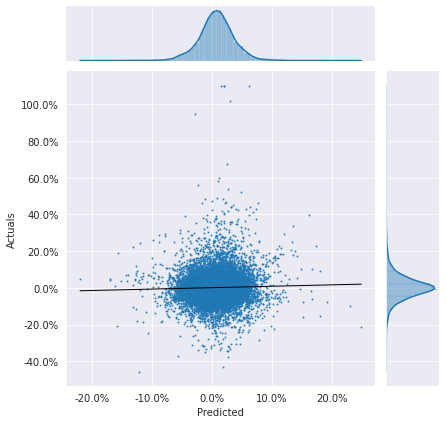

In [18]:
plot_preds_scatter(lr_predictions)

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


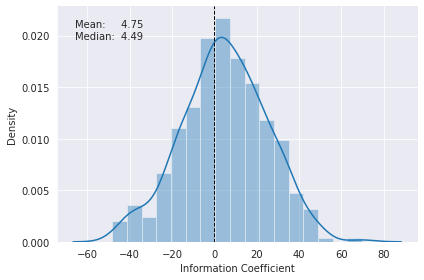

In [19]:
plot_ic_distribution(lr_scores)

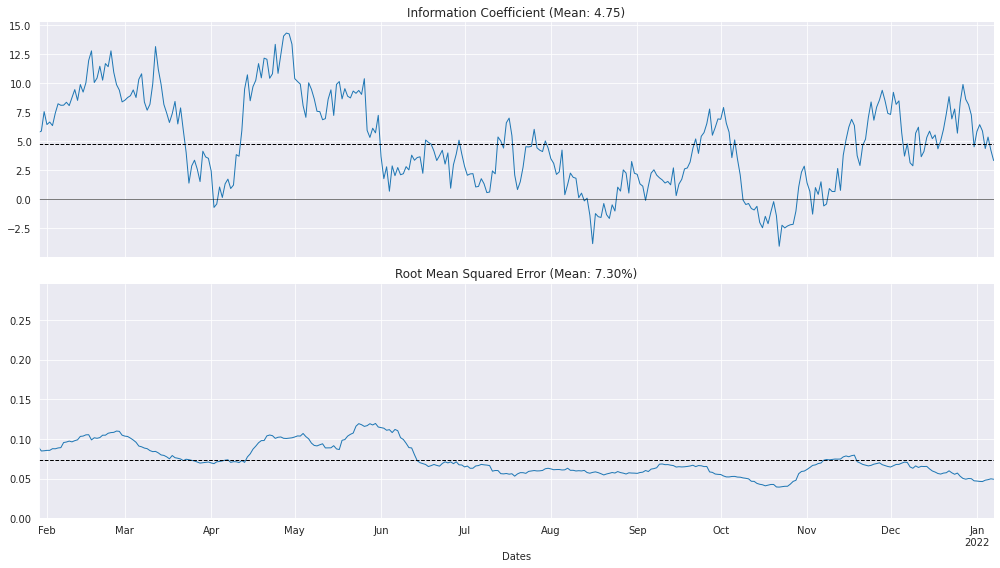

In [20]:
plot_rolling_ic(lr_scores)

In [21]:
# With Ridge Regression
ridge_alphas = np.logspace(-4, 4, 9)
#print(ridge_alphas)
ridge_alphas = sorted(list(ridge_alphas) + list(ridge_alphas * 5))
#ridge_alphas = ridge_alphas[:11]
print(ridge_alphas)
print(len(ridge_alphas))

[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0, 5000.0, 10000.0, 50000.0]
18


In [22]:
n_splits = int(1 * YEAR/test_period_length)
train_period_length = 30
test_period_length = 7
lookahead = 1

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

In [23]:
target = f'target_{lookahead}d'
X = X.drop([c for c in X.columns if 'year' in c], axis=1)

In [24]:
%%time
# Cross Validation with Ridge
ridge_coeffs, ridge_scores, ridge_predictions = {}, [], []

for alpha in ridge_alphas:
    print(alpha, end=' ', flush=True)
    start = time()
    model = Ridge(alpha=alpha,
                  fit_intercept=False,
                  random_state=42)

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)])

    coeffs = []
    
    try:
        for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
            X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
            X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]

            pipe.fit(X=X_train, y=y_train)
            y_pred = pipe.predict(X_test)

            preds = y_test.to_frame('actuals').assign(predicted=y_pred)
            preds_by_day = preds.groupby(level='Dates')
            scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,
                                                                       x.actuals)[0] * 100)
                                .to_frame('ic'),
                                preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,
                                                                                        y_true=x.actuals)))
                                .to_frame('rmse')], axis=1)

            ridge_scores.append(scores.assign(alpha=alpha))
            ridge_predictions.append(preds.assign(alpha=alpha))

            coeffs.append(pipe.named_steps['model'].coef_)
        ridge_coeffs[alpha] = np.mean(coeffs, axis=0)

    except IndexError: 
        print('Ran out of data for train/test splits')
        ridge_coeffs[alpha] = np.mean(coeffs, axis=0)

print('\n')

0.0001 0.0005 0.001 0.005 0.01 0.05 0.1 0.5 1.0 5.0 10.0 50.0 100.0 500.0 1000.0 5000.0 10000.0 50000.0 

CPU times: user 46.6 s, sys: 1min 28s, total: 2min 14s
Wall time: 22.5 s


In [25]:
# Save the ridge results
ridge_scores = pd.concat(ridge_scores)
ridge_scores.to_hdf(f'{model_dataDir}Ridge_Scores.h5', 'ridge/scores')

ridge_coeffs = pd.DataFrame(ridge_coeffs, index=X.columns).T
ridge_coeffs.to_hdf(f'{model_dataDir}Ridge_Coeffs.h5', 'ridge/coeffs')

ridge_predictions = pd.concat(ridge_predictions)
ridge_predictions.to_hdf(f'{model_dataDir}Ridge_Predictions.h5', 'ridge/predictions')

#  Reload the data
ridge_scores = pd.read_hdf(f'{model_dataDir}Ridge_Scores.h5', 'ridge/scores')
ridge_coeffs = pd.read_hdf(f'{model_dataDir}Ridge_Coeffs.h5', 'ridge/coeffs')
ridge_predictions = pd.read_hdf(f'{model_dataDir}Ridge_Predictions.h5', 'ridge/predictions')


In [26]:
# Evaluate the Ridge Results 
ridge_r, ridge_p = spearmanr(ridge_predictions.actuals, ridge_predictions.predicted)
print(f'Information Coefficient (overall): {ridge_r:.3%} (p-value: {ridge_p:.4%})')

Information Coefficient (overall): 2.373% (p-value: 0.0000%)


In [27]:
# Ridge Alpha IC scores
ridge_scores.groupby('alpha').ic.describe()

,count,mean,std,min,25%,50%,75%,max
alpha,,,,,,,,
0.0001,364.0,4.752191,19.981532,-48.279352,-7.879555,4.493927,18.243927,69.838057
0.0005,364.0,4.752191,19.981532,-48.279352,-7.879555,4.493927,18.243927,69.838057
0.0010,364.0,4.752191,19.981532,-48.279352,-7.879555,4.493927,18.243927,69.838057
0.0050,364.0,4.751246,19.980916,-48.279352,-7.879555,4.493927,18.243927,69.838057
0.0100,364.0,4.754861,19.980121,-47.995951,-7.879555,4.493927,18.243927,69.838057
0.0500,364.0,4.762146,19.977523,-47.995951,-7.879555,4.493927,18.243927,69.838057
0.1000,364.0,4.772656,19.964797,-47.995951,-7.879555,4.544534,18.395749,69.838057
0.5000,364.0,4.819649,19.975334,-47.995951,-7.737854,4.311741,18.446356,69.251012
1.0000,364.0,4.861247,19.969113,-47.894737,-7.737854,4.412955,18.466599,69.251012


In [28]:
ridge_scores.groupby('alpha').rmse.describe()

,count,mean,std,min,25%,50%,75%,max
alpha,,,,,,,,
0.0001,364.0,0.072718,0.038707,0.021066,0.046194,0.064407,0.087031,0.288670
0.0005,364.0,0.072718,0.038707,0.021066,0.046194,0.064407,0.087030,0.288669
0.0010,364.0,0.072718,0.038707,0.021066,0.046194,0.064407,0.087030,0.288669
0.0050,364.0,0.072718,0.038707,0.021066,0.046193,0.064409,0.087029,0.288667
0.0100,364.0,0.072718,0.038707,0.021065,0.046192,0.064411,0.087028,0.288664
0.0500,364.0,0.072716,0.038707,0.021064,0.046187,0.064426,0.087018,0.288641
0.1000,364.0,0.072714,0.038707,0.021062,0.046181,0.064432,0.087007,0.288614
0.5000,364.0,0.072699,0.038703,0.021046,0.046173,0.064432,0.086937,0.288427
1.0000,364.0,0.072684,0.038696,0.021029,0.046194,0.064431,0.086889,0.288249


In [29]:
ridge_scores.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6552 entries, 2022-01-01 to 2021-01-15
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ic      6552 non-null   float64
 1   rmse    6552 non-null   float64
 2   alpha   6552 non-null   float64
dtypes: float64(3)
memory usage: 204.8 KB


In [30]:
# Work around for 'ValueError: cannot reindex from a duplicate axis' error in the plot below
ridge_scores['Dates'] = ridge_scores.index
len_df = ridge_scores['alpha'].count()
temp_new_index = [c for c in range(1,len_df + 1)]
ridge_scores.index = temp_new_index

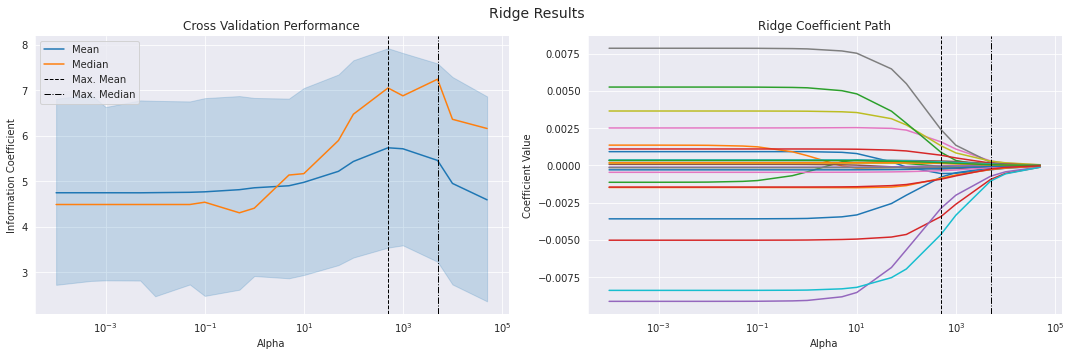

In [31]:
fig, axes = plt.subplots(ncols=2, sharex=True, figsize=(15, 5))

scores_by_alpha = ridge_scores.groupby('alpha').ic.agg(['mean', 'median'])
best_alpha_mean = scores_by_alpha['mean'].idxmax()
best_alpha_median = scores_by_alpha['median'].idxmax()



ax = sns.lineplot(x='alpha',
                  y='ic',
                  data=ridge_scores,
                  estimator=np.mean,
                  label='Mean',
                  ax=axes[0])

scores_by_alpha['median'].plot(logx=True,
                               ax=axes[0],
                               label='Median')

axes[0].axvline(best_alpha_mean,
                ls='--',
                c='k',
                lw=1,
                label='Max. Mean')
axes[0].axvline(best_alpha_median,
                ls='-.',
                c='k',
                lw=1,
                label='Max. Median')
axes[0].legend()
axes[0].set_xscale('log')
axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('Information Coefficient')
axes[0].set_title('Cross Validation Performance')

ridge_coeffs.plot(logx=True,
                  legend=False,
                  ax=axes[1],
                  title='Ridge Coefficient Path')

axes[1].axvline(best_alpha_mean,
                ls='--',
                c='k',
                lw=1,
                label='Max. Mean')
axes[1].axvline(best_alpha_median,
                ls='-.',
                c='k',
                lw=1,
                label='Max. Median')
axes[1].set_xlabel('Alpha')
axes[1].set_ylabel('Coefficient Value')

fig.suptitle('Ridge Results', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)

In [32]:
# Switch the index back to DateTimeIndex
#ridge_scores.index = ridge_scores['Dates']
#ridge_scores.drop(['Dates'], axis = 1,inplace=True)

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


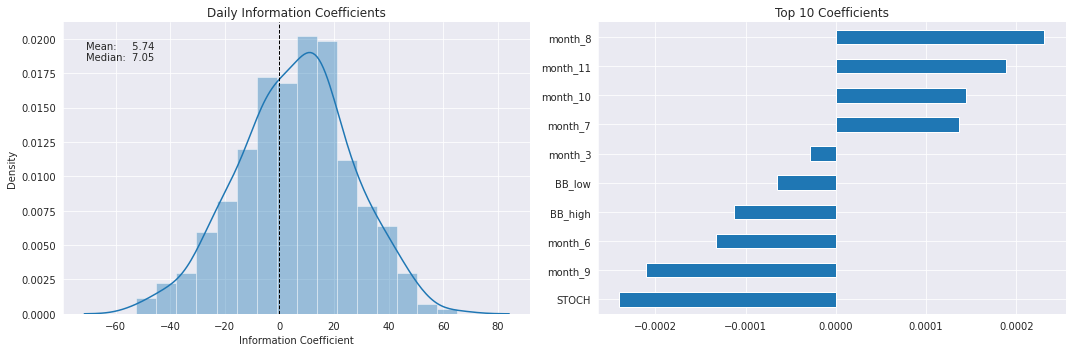

In [33]:
best_alpha = ridge_scores.groupby('alpha').ic.mean().idxmax()
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
plot_ic_distribution(ridge_scores[ridge_scores.alpha == best_alpha],
                     ax=axes[0])
axes[0].set_title('Daily Information Coefficients')
top_coeffs = ridge_coeffs.loc[best_alpha].abs().sort_values().head(10).index
top_coeffs.tolist()
ridge_coeffs.loc[best_alpha, top_coeffs].sort_values().plot.barh(ax=axes[1],
                                                                 title='Top 10 Coefficients')
sns.despine()
fig.tight_layout()

These observations are meant to draw conclusions about the relative importance of the coefficients by commparing their absolute magnitude. The top 10 most relevant coefficients based on the IC mean are on the right, averaged over all the trained models.

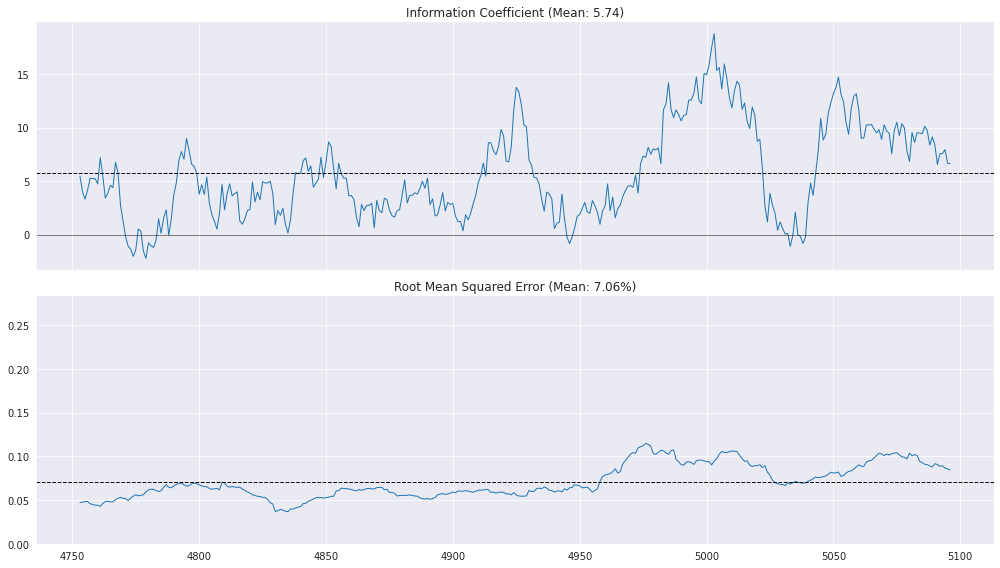

In [34]:
plot_rolling_ic(ridge_scores[ridge_scores.alpha==best_alpha])

In [35]:
# With Lasso Regression

# CV parameters
lasso_alphas = np.logspace(-10, 1, 8)
#lasso_alphas = sorted(list(lasso_alphas) + list(lasso_alphas * 5))

print(lasso_alphas)
print(len(lasso_alphas))

train_period_length = 30
test_period_length = 7
YEAR = 365
n_splits = int(1 * YEAR / test_period_length) # two years
lookahead = 1


[1.00000000e-10 3.72759372e-09 1.38949549e-07 5.17947468e-06
 1.93069773e-04 7.19685673e-03 2.68269580e-01 1.00000000e+01]
8


In [36]:
cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

In [37]:
# Lasso Cross-validation
target = f'target_{lookahead}d'
scaler = StandardScaler()
X = X.drop([c for c in X.columns if 'year' in c], axis=1)

In [38]:
%%time
lasso_coeffs, lasso_scores, lasso_predictions = {}, [], []
for alpha in lasso_alphas:
    print(alpha, end=' ', flush=True)
    model = Lasso(alpha=alpha,
                  fit_intercept=False,  # StandardScaler centers data
                  random_state=42,
                  tol=1e-3,
                  max_iter=1000,
                  warm_start=True,
                  selection='random')

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)])
    coeffs = []
    
    try:
        for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
            t = time()
            X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
            X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]

            pipe.fit(X=X_train, y=y_train)
            y_pred = pipe.predict(X_test)

            preds = y_test.to_frame('actuals').assign(predicted=y_pred)
            preds_by_day = preds.groupby(level='Dates')
            scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,
                                                                       x.actuals)[0] * 100)
                                .to_frame('ic'),
                                preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,
                                                                                        y_true=x.actuals)))
                                .to_frame('rmse')],
                               axis=1)

            lasso_scores.append(scores.assign(alpha=alpha))
            lasso_predictions.append(preds.assign(alpha=alpha))

            coeffs.append(pipe.named_steps['model'].coef_)
        lasso_coeffs[alpha] = np.mean(coeffs, axis=0)
    except IndexError: 
        print('Ran out of data for train/test splits')
        lasso_coeffs[alpha] = np.mean(coeffs, axis=0)

1e-10 

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.567e+00, tolerance: 3.228e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.621e+00, tolerance: 3.398e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You mig

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.166e+00, tolerance: 4.895e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.213e+00, tolerance: 4.719e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You mig

3.727593720314938e-09 

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.302e+00, tolerance: 1.116e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.163e+00, tolerance: 1.093e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You mig

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.808e+00, tolerance: 4.450e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.202e-02, tolerance: 4.009e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You mig

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.670e+00, tolerance: 1.278e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.016e+00, tolerance: 1.129e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You mig

1.389495494373136e-07 

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.019e-01, tolerance: 3.228e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.870e+00, tolerance: 4.175e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You mig

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.076e+00, tolerance: 5.244e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.482e+00, tolerance: 1.377e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You mig

5.179474679231212e-06 

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.825e-01, tolerance: 4.175e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.129e+00, tolerance: 5.039e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You mig

0.00019306977288832496 

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.451e-03, tolerance: 2.430e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.729e-03, tolerance: 4.324e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


0.007196856730011514 

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.504e-02, tolerance: 4.324e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.504e-02, tolerance: 4.0

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.795e-02, tolerance: 1.183e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.795e-02, tolerance: 1.287e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You mig

0.26826957952797276 

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.025e-02, tolerance: 1.403e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.025e-02, tolerance: 1.116e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You mig

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRCons

10.0 

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRCons

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRCons

CPU times: user 40.5 s, sys: 1min 29s, total: 2min 9s
Wall time: 18.1 s


/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRCons

In [39]:
# Persist Lasso outputs
lasso_scores = pd.concat(lasso_scores)
lasso_scores.to_hdf(f'{model_dataDir}Lasso_Scores.h5', 'lasso/scores')

lasso_coeffs = pd.DataFrame(lasso_coeffs, index=X.columns).T
lasso_coeffs.to_hdf(f'{model_dataDir}Lasso_Coeffs.h5', 'lasso/coeffs')

lasso_predictions = pd.concat(lasso_predictions)
lasso_predictions.to_hdf(f'{model_dataDir}Lasso_Predictions.h5', 'lasso/predictions')



In [40]:
# Results
best_alpha = lasso_scores.groupby('alpha').ic.mean().idxmax()
preds = lasso_predictions[lasso_predictions.alpha==best_alpha]

lasso_r, lasso_p = spearmanr(preds.actuals, preds.predicted)
print(f'Information Coefficient (overall): {lasso_r:.3%} (p-value: {lasso_p:.4%})')

Information Coefficient (overall): 3.884% (p-value: 0.0004%)


In [41]:
lasso_scores.groupby('alpha').ic.agg(['mean', 'median'])

,mean,median
alpha,,
1.000000e-10,4.810640,4.453441
3.727594e-09,4.810640,4.453441
1.389495e-07,4.806914,4.453441
5.179475e-06,4.834275,4.402834
1.930698e-04,4.992047,6.032389
7.196857e-03,4.115266,5.344130
2.682696e-01,NaN,NaN
1.000000e+01,NaN,NaN


In [42]:
lasso_scores.groupby('alpha').rmse.agg(['mean', 'median'])

,mean,median
alpha,,
1.000000e-10,0.072839,0.063730
3.727594e-09,0.072839,0.063735
1.389495e-07,0.072830,0.063875
5.179475e-06,0.072909,0.064677
1.930698e-04,0.072588,0.064964
7.196857e-03,0.069902,0.060700
2.682696e-01,0.069139,0.059926
1.000000e+01,0.069139,0.059926


In [43]:
# Work around for 'ValueError: cannot reindex from a duplicate axis' error in the plot below
lasso_scores['Dates'] = lasso_scores.index
len_df = lasso_scores['alpha'].count()
temp_new_index = [c for c in range(1,len_df + 1)]
lasso_scores.index = temp_new_index

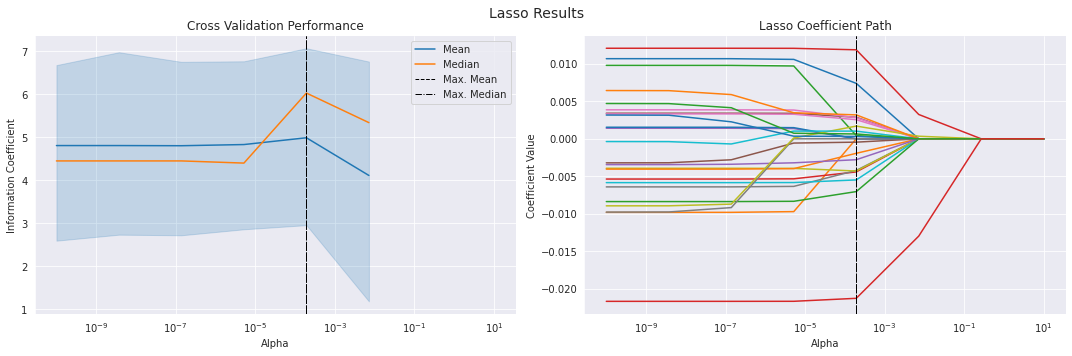

In [44]:
# Lasso Coefficient paths
fig, axes = plt.subplots(ncols=2, sharex=True, figsize=(15, 5))

scores_by_alpha = lasso_scores.groupby('alpha').ic.agg(['mean', 'median'])
best_alpha_mean = scores_by_alpha['mean'].idxmax()
best_alpha_median = scores_by_alpha['median'].idxmax()

ax = sns.lineplot(x='alpha', y='ic', data=lasso_scores, estimator=np.mean, label='Mean', ax=axes[0])

scores_by_alpha['median'].plot(logx=True, ax=axes[0], label='Median')

axes[0].axvline(best_alpha_mean, ls='--', c='k', lw=1, label='Max. Mean')
axes[0].axvline(best_alpha_median, ls='-.', c='k', lw=1, label='Max. Median')
axes[0].legend()
axes[0].set_xscale('log')
axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('Information Coefficient')
axes[0].set_title('Cross Validation Performance')

lasso_coeffs.plot(logx=True, legend=False, ax=axes[1], title='Lasso Coefficient Path')
axes[1].axvline(best_alpha_mean, ls='--', c='k', lw=1, label='Max. Mean')
axes[1].axvline(best_alpha_median, ls='-.', c='k', lw=1, label='Max. Median')
axes[1].set_xlabel('Alpha')
axes[1].set_ylabel('Coefficient Value')

fig.suptitle('Lasso Results', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.9)
sns.despine();

In [45]:
# Switch the index back to DateTimeIndex
#lasso_scores.index = lasso_scores['Dates']
#lasso_scores.drop(['Dates'], axis = 1,inplace=True)

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


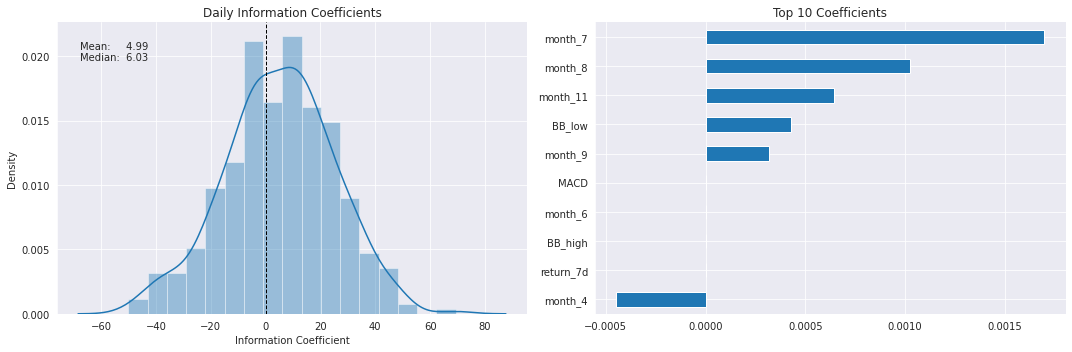

In [46]:
best_alpha = lasso_scores.groupby('alpha').ic.mean().idxmax()

fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
plot_ic_distribution(lasso_scores[lasso_scores.alpha==best_alpha], ax=axes[0])
axes[0].set_title('Daily Information Coefficients')

top_coeffs = lasso_coeffs.loc[best_alpha].abs().sort_values().head(10).index
top_coeffs.tolist()
lasso_coeffs.loc[best_alpha, top_coeffs].sort_values().plot.barh(ax=axes[1], title='Top 10 Coefficients')

sns.despine()
fig.tight_layout();

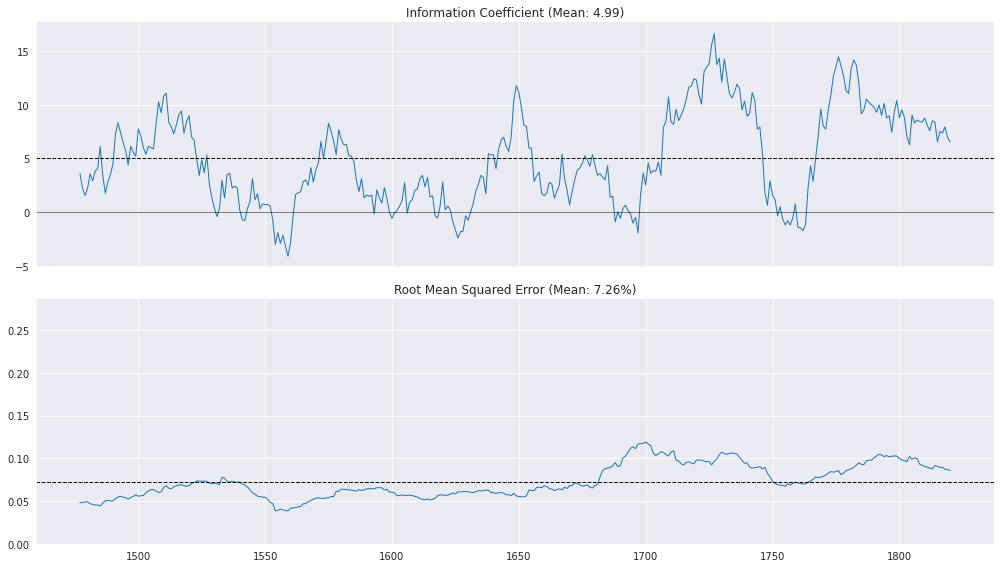

In [47]:
plot_rolling_ic(lasso_scores[lasso_scores.alpha==best_alpha])

In [48]:
# Switch the index back to DateTimeIndex
lasso_scores.index = lasso_scores['Dates']
lasso_scores.drop(['Dates'], axis = 1,inplace=True)
# Switch the index back to DateTimeIndex
ridge_scores.index = ridge_scores['Dates']
ridge_scores.drop(['Dates'], axis = 1,inplace=True)

In [49]:
# Compare results
best_ridge_alpha = ridge_scores.groupby('alpha').ic.mean().idxmax()
best_ridge_preds = ridge_predictions[ridge_predictions.alpha==best_ridge_alpha]
best_ridge_scores = ridge_scores[ridge_scores.alpha==best_ridge_alpha]

In [50]:
best_lasso_alpha = lasso_scores.groupby('alpha').ic.mean().idxmax()
best_lasso_preds = lasso_predictions[lasso_predictions.alpha==best_lasso_alpha]
best_lasso_scores = lasso_scores[lasso_scores.alpha==best_lasso_alpha]

In [51]:
lr_scores

,ic,rmse
Dates,,
2022-01-01,25.809717,0.027676
2022-01-02,-5.465587,0.052116
2022-01-03,5.809717,0.046551
2022-01-04,8.441296,0.095246
2022-01-05,23.866397,0.040442
...,...,...
2021-01-11,11.093117,0.081240
2021-01-12,3.097166,0.051334
2021-01-13,-0.951417,0.049812


In [52]:
best_ridge_scores

,ic,rmse,alpha
Dates,,,
2022-01-01,31.012146,0.025682,500.0
2022-01-02,-5.000000,0.052594,500.0
2022-01-03,0.020243,0.043102,500.0
2022-01-04,20.242915,0.102773,500.0
2022-01-05,12.429150,0.043922,500.0
...,...,...,...
2021-01-11,17.894737,0.061296,500.0
2021-01-12,0.141700,0.059927,500.0
2021-01-13,-7.530364,0.048358,500.0


In [53]:
best_lasso_scores

,ic,rmse,alpha
Dates,,,
2022-01-01,25.829960,0.026170,0.000193
2022-01-02,-1.437247,0.052035,0.000193
2022-01-03,6.315789,0.043723,0.000193
2022-01-04,8.441296,0.099784,0.000193
2022-01-05,20.931174,0.042336,0.000193
...,...,...,...
2021-01-11,10.506073,0.066896,0.000193
2021-01-12,5.060729,0.055643,0.000193
2021-01-13,1.801619,0.047345,0.000193


In [55]:
df = pd.concat([lr_scores.assign(Model='Linear Regression'),
               best_ridge_scores.assign(Model='Ridge Regression'),
               best_lasso_scores.assign(Model='Lasso Regression')]).drop('alpha', axis=1)
df.columns = ['IC', 'RMSE', 'Model']

In [56]:
df

,IC,RMSE,Model
Dates,,,
2022-01-01,25.809717,0.027676,Linear Regression
2022-01-02,-5.465587,0.052116,Linear Regression
2022-01-03,5.809717,0.046551,Linear Regression
2022-01-04,8.441296,0.095246,Linear Regression
2022-01-05,23.866397,0.040442,Linear Regression
...,...,...,...
2021-01-11,10.506073,0.066896,Lasso Regression
2021-01-12,5.060729,0.055643,Lasso Regression
2021-01-13,1.801619,0.047345,Lasso Regression


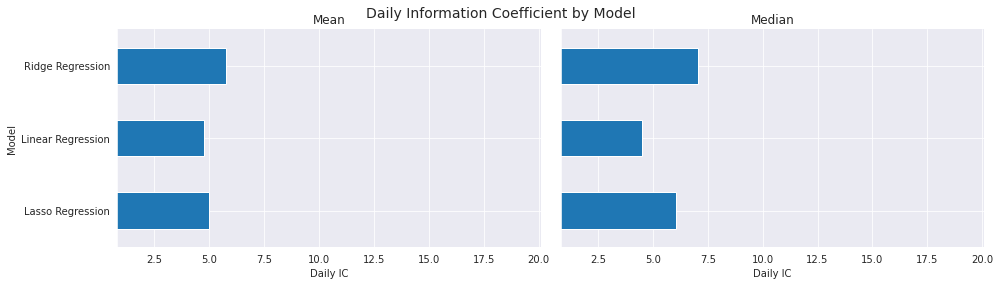

In [57]:
scores = df.groupby('Model').IC.agg(['mean', 'median'])
fig, axes = plt.subplots(ncols=2, figsize=(14,4), sharey=True, sharex=True)

scores['mean'].plot.barh(ax=axes[0], xlim=(0.85, 20), title='Mean')
scores['median'].plot.barh(ax=axes[1], xlim=(0.8, 20.1), title='Median')
axes[0].set_xlabel('Daily IC')
axes[1].set_xlabel('Daily IC')

fig.suptitle('Daily Information Coefficient by Model', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)